<a href="https://colab.research.google.com/github/rushweigelt/personal_ml_projects/blob/master/ml_trading/ml_trading3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount personal google drive to access files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive
%cd My\ Drive
%cd ml_trading

/content/drive
/content/drive/My Drive
/content/drive/My Drive/ml_trading


In [4]:
!pip install tensorflow
!pip install yahoo_fin

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [0]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [0]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

In [0]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [0]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 100
# Apple stock market
ticker = "AAL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [0]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [74]:
# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.0113 - mean_absolute_error: 0.1017
Epoch 00001: val_loss improved from inf to 0.00363, saving model to results/2020-06-08_AAL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
45/45 [==============================] - 7s 150ms/step - loss: 0.0113 - mean_absolute_error: 0.1017 - val_loss: 0.0036 - val_mean_absolute_error: 0.0628
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.0732
Epoch 00002: val_loss improved from 0.00363 to 0.00300, saving model to results/2020-06-08_AAL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
45/45 [==============================] - 5s 107ms/step - loss: 0.0051 - mean_absolute_error: 0.0732 - val_loss: 0.0030 - val_mean_absolute_error: 0.0560
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0634
Epoch 00003: val_loss improved from 0.00300 to 0.00155, saving model to re

In [0]:
!tensorboard --logdir="logs"

In [0]:
##################################################
#Dont run unless loading previous trained weights
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [75]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 2.5312027323912316


In [0]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

In [76]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 20.11$


In [0]:
def plot_graph(model, data):
  y_test = data["y_test"]
  X_test = data["X_test"]
  y_pred = model.predict(X_test)
  y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
  y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
  # last 200 days, feel free to edit that
  plt.plot(y_test[-200:], c='b')
  plt.plot(y_pred[-200:], c='r')
  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.legend(["Actual Price", "Predicted Price"])
  plt.show()

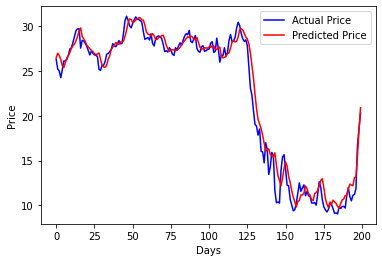

In [77]:
plot_graph(model, data)

In [0]:
#calc the accuracy score by converting the predicted price to 0 or 1 (0 indicates price went down, 1 indicates up)
def get_accuracy(model, data):
  y_test = data["y_test"]
  X_test = data["X_test"]
  y_pred = model.predict(X_test)
  y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
  y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
  y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
  y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
  return accuracy_score(y_test, y_pred)

In [78]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5062586926286509


In [0]:
def loop_training():
  #lookout_steps (1 is next day)
  LOOKUP_STEPS = [1, 2, 3, 4, 5, 7]#14, 21, 28, 42, 56, 70]
  # Window size or the sequence length
  N_STEPS = 100
  # Lookup step, 1 is the next day
  LOOKUP_STEP = 1
  # test ratio size, 0.2 is 20%
  TEST_SIZE = 0.2
  # features to use
  FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
  # date now
  date_now = time.strftime("%Y-%m-%d")
  ### model parameters
  N_LAYERS = 3
  # LSTM cell
  CELL = LSTM
  # 256 LSTM neurons
  UNITS = 256
  # 40% dropout
  DROPOUT = 0.4
  # whether to use bidirectional RNNs
  BIDIRECTIONAL = False
  ### training parameters
  # mean absolute error loss
  # LOSS = "mae"
  # huber loss
  LOSS = "huber_loss"
  OPTIMIZER = "adam"
  BATCH_SIZE = 64
  EPOCHS = 100
  # Apple stock market
  ticker = "AAL"
  ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
  # model name to save, making it as unique as possible based on parameters
  model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
  if BIDIRECTIONAL:
      model_name += "-b"
  
  

  # construct the model
  for num in LOOKUP_STEPS:
    LOOKUP_STEP = num
    # load the data
    data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
    # save the dataframe
    data["df"].to_csv(ticker_data_filename)
    model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS, dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

    # some tensorflow callbacks
    checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=0)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

    history = model.fit(data["X_train"], data["y_train"],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(data["X_test"], data["y_test"]),
                        callbacks=[checkpointer, tensorboard],
                        verbose=1)

    model.save(os.path.join("results", model_name) + ".h5")


    #calculate mean absolute error
    data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                    feature_columns=FEATURE_COLUMNS, shuffle=False)
    # evaluate the model
    mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
    # calculate the mean absolute error (inverse scaling)
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
    print("Mean Absolute Error:", mean_absolute_error)
    #plot
    plot_graph(model, data)
    #predict
    # predict the future price
    future_price = predict(model, data)
    print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
    accuracy = get_accuracy(model, data)
    print(str(LOOKUP_STEP) + ":", "Accuracy Score:", accuracy)
    foo = model_name + " " + str(LOOKUP_STEP) + " " + str(round(future_price, 2)) + " " + str(round(mean_absolute_error, 2)) + " " + str(round(accuracy, 2))
    write_results(foo)


In [0]:
def write_results(string):
  with open('/content/drive/My Drive/ml_trading/result.txt', 'a') as f:
    f.write(string + "\n")
    f.close()



Epoch 1/100
45/45 [==============================] - 7s 151ms/step - loss: 0.0130 - mean_absolute_error: 0.1122 - val_loss: 0.0046 - val_mean_absolute_error: 0.0685
Epoch 2/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0052 - mean_absolute_error: 0.0740 - val_loss: 0.0031 - val_mean_absolute_error: 0.0578
Epoch 3/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0042 - mean_absolute_error: 0.0658 - val_loss: 0.0023 - val_mean_absolute_error: 0.0485
Epoch 4/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0033 - mean_absolute_error: 0.0592 - val_loss: 0.0013 - val_mean_absolute_error: 0.0380
Epoch 5/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0025 - mean_absolute_error: 0.0514 - val_loss: 0.0011 - val_mean_absolute_error: 0.0342
Epoch 6/100
45/45 [==============================] - 5s 108ms/step - loss: 0.0024 - mean_absolute_error: 0.0509 - val_loss: 9.1912e-04 - val_mean_absolute_error: 0.0313
Epoch 

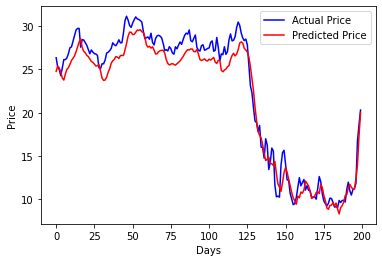

Future price after 1 days is 17.74$
1: Accuracy Score: 0.5396383866481224
Epoch 1/100
45/45 [==============================] - 6s 142ms/step - loss: 0.0128 - mean_absolute_error: 0.1092 - val_loss: 0.0047 - val_mean_absolute_error: 0.0714
Epoch 2/100
45/45 [==============================] - 5s 104ms/step - loss: 0.0055 - mean_absolute_error: 0.0766 - val_loss: 0.0043 - val_mean_absolute_error: 0.0675
Epoch 3/100
45/45 [==============================] - 5s 102ms/step - loss: 0.0044 - mean_absolute_error: 0.0684 - val_loss: 0.0043 - val_mean_absolute_error: 0.0696
Epoch 4/100
45/45 [==============================] - 5s 114ms/step - loss: 0.0040 - mean_absolute_error: 0.0644 - val_loss: 0.0018 - val_mean_absolute_error: 0.0444
Epoch 5/100
45/45 [==============================] - 5s 104ms/step - loss: 0.0030 - mean_absolute_error: 0.0561 - val_loss: 0.0014 - val_mean_absolute_error: 0.0382
Epoch 6/100
45/45 [==============================] - 5s 103ms/step - loss: 0.0024 - mean_absolute_err

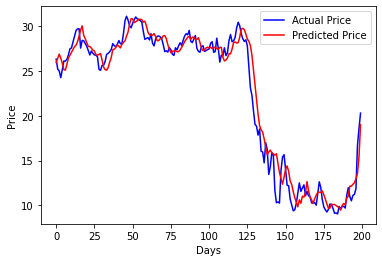

Future price after 2 days is 19.22$
2: Accuracy Score: 0.47983310152990266
Epoch 1/100
45/45 [==============================] - 7s 149ms/step - loss: 0.0124 - mean_absolute_error: 0.1060 - val_loss: 0.0041 - val_mean_absolute_error: 0.0662
Epoch 2/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0049 - mean_absolute_error: 0.0716 - val_loss: 0.0033 - val_mean_absolute_error: 0.0595
Epoch 3/100
45/45 [==============================] - 5s 106ms/step - loss: 0.0040 - mean_absolute_error: 0.0638 - val_loss: 0.0025 - val_mean_absolute_error: 0.0517
Epoch 4/100
45/45 [==============================] - 5s 106ms/step - loss: 0.0035 - mean_absolute_error: 0.0594 - val_loss: 0.0022 - val_mean_absolute_error: 0.0486
Epoch 5/100
45/45 [==============================] - 5s 107ms/step - loss: 0.0029 - mean_absolute_error: 0.0547 - val_loss: 0.0021 - val_mean_absolute_error: 0.0490
Epoch 6/100
45/45 [==============================] - 5s 106ms/step - loss: 0.0021 - mean_absolute_er

In [0]:
loop_training()